In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

Only blocks and matrix is needed to initialize a ``City`` model

In [2]:
from masterplan_tools.models import City 

aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

city_model = City(accessibility_matrix, aggregated_blocks)

``Block`` can be accessed via ``id``

``ServiceType`` entity can be obtained the same way by ``name``

In [3]:
block_123 = city_model[123]
service_type_schools = city_model['schools']

We can calculate, how much the service should supply to satisfy population needs

In [4]:
city_model['schools'].calculate_in_need(110)

14

``ServiceType`` is an entity, which describes certain service types available for the city, but doesn't provide geospatial services information (e.g. schools locations)

In [5]:
city_model.service_types

[ServiceType(name='kindergartens', accessibility=10, demand=61),
 ServiceType(name='schools', accessibility=15, demand=120),
 ServiceType(name='recreational_areas', accessibility=15, demand=6000),
 ServiceType(name='hospitals', accessibility=60, demand=9),
 ServiceType(name='pharmacies', accessibility=10, demand=50),
 ServiceType(name='policlinics', accessibility=15, demand=27)]

In [6]:
city_model.add_service_type('bakeries', accessibility=30, demand=100)
city_model['bakeries']

ServiceType(name='bakeries', accessibility=30, demand=100)

But now we can aggregate the info directly to the ``Block`` of the ``City`` from the ``GeoDataFrame``

In [7]:
bakeries = gpd.read_file(os.path.join(example_data_path, "bakeries.geojson")).to_crs(local_crs)
city_model.update_service_type_layer(service_type=city_model['bakeries'], gdf=bakeries)
print('Block bakeries:', city_model[100]['bakeries'])

Block bakeries: {'capacity': 284, 'demand': 173}


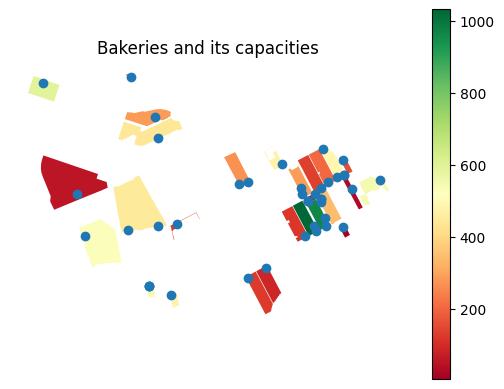

In [8]:
import matplotlib.pyplot as plt

bakeries_blocks = list(filter(lambda x : x['bakeries']['capacity'] > 0, city_model.blocks))
gdf = gpd.GeoDataFrame(map(lambda block : {"id":block.id, "capacity": block['bakeries']['capacity'], "geometry": block.geometry}, bakeries_blocks))
fig, ax = plt.subplots()
ax.set_axis_off()
ax.set_title('Bakeries and its capacities')
gdf.plot(ax=ax, alpha=1, column='capacity', legend=True, cmap='RdYlGn')
bakeries.plot(ax=ax)
plt.show()

In [ ]:
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet")).to_crs(local_crs)
city_model.update_service_type_layer(service_type=city_model['kindergartens'], gdf=kindergartens)
service_type = 'kindergartens'

In [9]:
from masterplan_tools.method.provision import Provision
prov = Provision(city_model=city_model)

In [10]:
prov = prov.calculate_provision(service_type='bakeries')

127 27
14.0
21.0
0.0
26.0
13.0
27.0
35.0
26.0
11.0
0.0
19.0
11.0
11.0
14.0
0.0
10.0
17.0
19.0
12.0
14.0
14.0
14.0
10.0
0.0
6.0
11.0
0.0
10.0
13.0
10.0
14.0
14.0
12.0
16.0
10.0
0.0
15.0
20.0
17.0
0.0
20.0
0.0
13.0
22.0
15.0
14.0
20.0
12.0
20.0
13.0
16.0
20.0
15.0
13.0
10.0
16.0
0.0
7.0
9.0
23.0
22.0
22.0
23.0
23.0
25.0
0.0
0.0
15.0
17.0
23.0
19.0
16.0
15.0
9.0
15.0
14.0
15.0
12.0
0.0
18.0
21.0
17.0
16.0
17.0
17.0
13.0
9.0
0.0
0.0
0.0
0.0
11.0
0.0
0.0
0.0
0.0
8.0
13.0
14.0
13.0
11.0
8.0
15.0
0.0
14.0
16.0
12.0
5.0
0.0
5.0
8.0
14.0
6.0
0.0
22.0
0.0
19.0
13.0
12.0
18.0
17.0
9.0
14.0
22.0
14.0
5.0
126 27
14.0
21.0
0.0
26.0
13.0
27.0
35.0
26.0
11.0
0.0
19.0
11.0
11.0
14.0
0.0
10.0
17.0
19.0
12.0
14.0
14.0
14.0
10.0
0.0
6.0
11.0
0.0
10.0
13.0
10.0
14.0
14.0
12.0
16.0
10.0
0.0
15.0
20.0
17.0
0.0
20.0
0.0
13.0
22.0
15.0
14.0
20.0
12.0
20.0
13.0
16.0
20.0
15.0
13.0
10.0
16.0
0.0
7.0
9.0
23.0
22.0
22.0
23.0
23.0
25.0
0.0
0.0
15.0
17.0
23.0
19.0
16.0
15.0
9.0
15.0
14.0
15.0
12.0
0.0
18.0
21.0
17.0

KeyboardInterrupt: 

In [12]:
graph = city_model.graph
demand_blocks = list(filter(lambda b : b[service_type]['demand'] > 0, graph.nodes))
capacity_blocks = list(filter(lambda b : b[service_type]['capacity'] > 0, graph.nodes))
for demand_block in demand_blocks:
  demand = demand_block[service_type]['demand']
  graph.nodes[demand_block]['demand'] = demand
  graph.nodes[demand_block]['demand_left'] = demand
  graph.nodes[demand_block]['demand_within'] = 0
  graph.nodes[demand_block]['demand_without'] = 0
for capacity_block in capacity_blocks:
  capacity = capacity_block[service_type]['capacity']
  graph.nodes[capacity_block]['capacity'] = capacity
  graph.nodes[capacity_block]['capacity_left'] = capacity
result_blocks = demand_blocks.copy()

In [13]:
def get_sorted_neighbors(block):
  return sorted(capacity_blocks, key=lambda b : graph[block][b]['weight'])

In [15]:
from masterplan_tools.models import Block

result : dict[Block, dict[str, int]]
while len(demand_blocks)>0 and len(capacity_blocks)>0:
  for demand_block in demand_blocks:
    neighbors = get_sorted_neighbors(demand_block)
    if len(neighbors) == 0 : break
    capacity_block = neighbors[0]
    graph.nodes[demand_block]['demand_left'] -= 1
    if graph[demand_block][capacity_block]['weight'] <= city_model[service_type].accessibility : graph.nodes[demand_block]['demand_within'] += 1
    else : graph.nodes[demand_block]['demand_without'] += 1
    if graph.nodes[demand_block]['demand_left'] == 0 : demand_blocks.remove(demand_block)
    graph.nodes[capacity_block]['capacity_left'] -= 1
    if graph.nodes[capacity_block]['capacity_left'] == 0 : capacity_blocks.remove(capacity_block)

In [16]:
def result_to_gdf(result_blocks):
  result = []
  for block in result_blocks:
    result.append({'id': block.id, "geometry": block.geometry, "provision": graph.nodes[block]['demand_within'] / graph.nodes[block]['demand']})
  return gpd.GeoDataFrame(result)

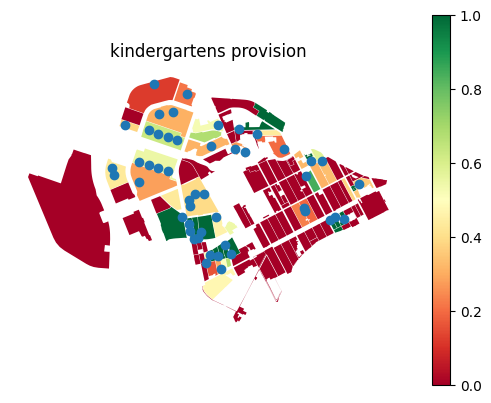

In [17]:
gdf = result_to_gdf(result_blocks).set_crs(local_crs)
fig, ax = plt.subplots()
ax.set_axis_off()
ax.set_title(f'{service_type} provision')
gdf.plot(ax=ax, alpha=1, column='provision', legend=True, cmap='RdYlGn')
kindergartens.plot(ax=ax, alpha=1)
plt.show()